## Project: Build a Traffic Sign Recognition Program
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

Overview
---
In this project, I will use convolutional neural networks to classify traffic signs.

The models will be trained and validated using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The Project
---
The goals / steps of this project are the following:
* Load the data set
* Explore, summarize and visualize the data set
* Design, train and test a model architecture
* Analyze top-1 and top-3 accuracy
* Visualize feature maps for the convolutional layers

### Dependencies

In [1]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import tensorflow as tf
import sys
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from matplotlib import __version__ as plt__version
from math import ceil, pow

%matplotlib inline

print('Python', sys.version)
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', plt__version)
print('Tensorflow', tf.__version__)
print('Scikit-learn', sklearn.__version__)

A4_PORTRAIT = (8.27, 11.69)
A4_LANDSCAPE = A4_PORTRAIT[::-1]

Python 3.6.3 (default, Oct  4 2017, 07:40:14) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.37)]
Numpy 1.13.3
Pandas 0.21.0
Matplotlib 2.1.0
Tensorflow 1.4.0
Scikit-learn 0.19.1


### Loading the data

In [2]:
# Load pickled data
training_file = 'data/train.p'
validation_file= 'data/valid.p'
testing_file = 'data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']
signnames = pd.read_csv('signnames.csv')['SignName']

---
## Dataset exploration

In [3]:
n_train = y_train.size
n_valid = y_valid.size
n_test = y_test.size
image_shape = x_train.shape[1:]
n_classes = np.unique(y_train).size

print("Number of training examples", n_train)
print("Number of validation examples", n_valid)
print("Number of testing examples", n_test)
print("Image data shape", image_shape)
print("Number of classes", n_classes)

Number of training examples 34799
Number of validation examples 4410
Number of testing examples 12630
Image data shape (32, 32, 3)
Number of classes 43


### Visualization of a few training examples

Speed limit (20km/h)


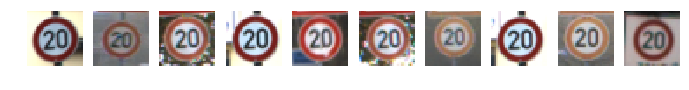

Speed limit (30km/h)


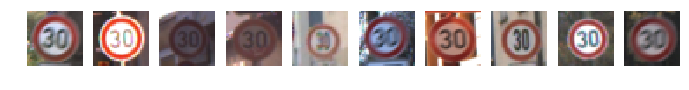

Speed limit (50km/h)


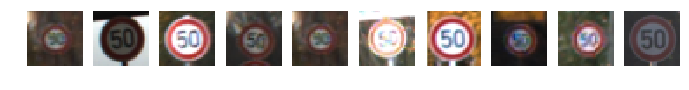

Speed limit (60km/h)


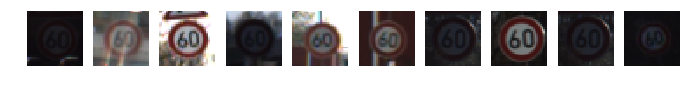

Speed limit (70km/h)


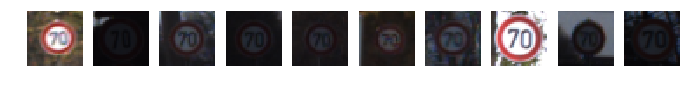

Speed limit (80km/h)


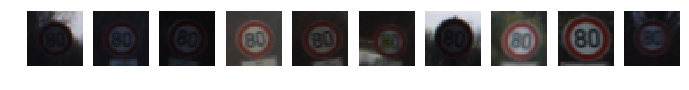

End of speed limit (80km/h)


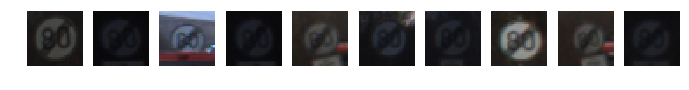

Speed limit (100km/h)


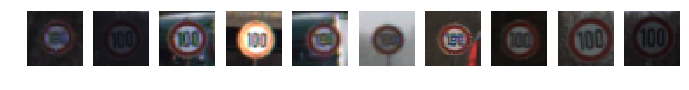

Speed limit (120km/h)


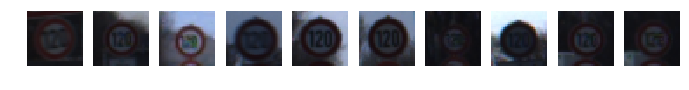

No passing


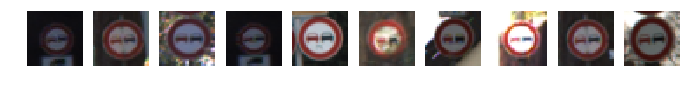

No passing for vehicles over 3.5 metric tons


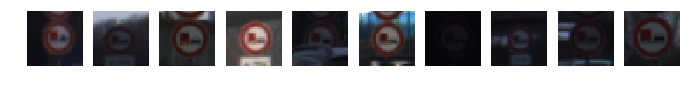

Right-of-way at the next intersection


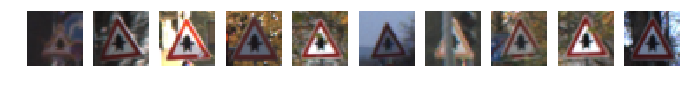

Priority road


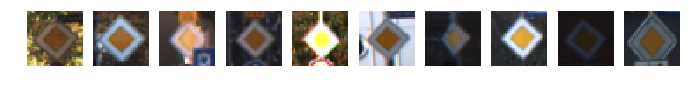

Yield


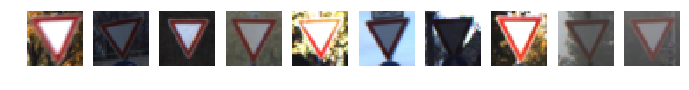

Stop


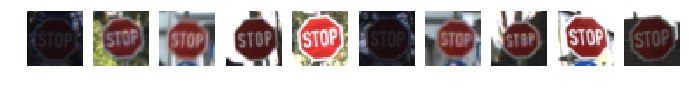

No vehicles


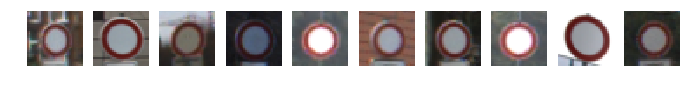

Vehicles over 3.5 metric tons prohibited


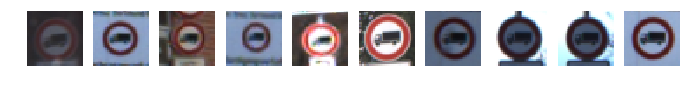

No entry


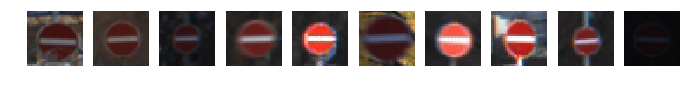

General caution


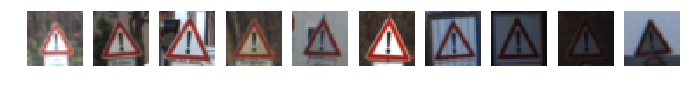

Dangerous curve to the left


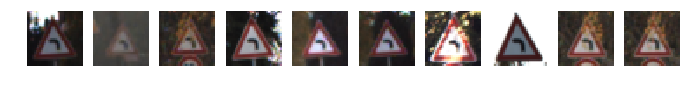

Dangerous curve to the right


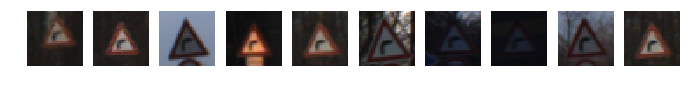

Double curve


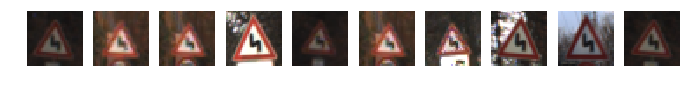

Bumpy road


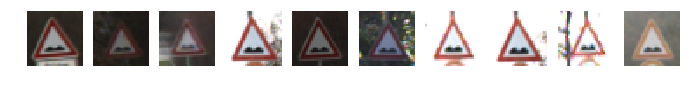

Slippery road


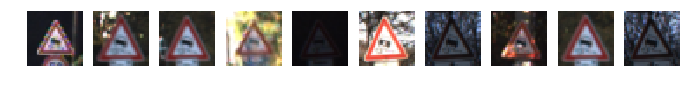

Road narrows on the right


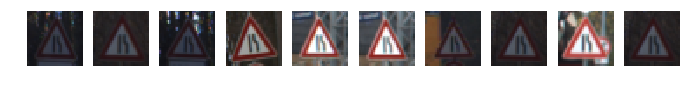

Road work


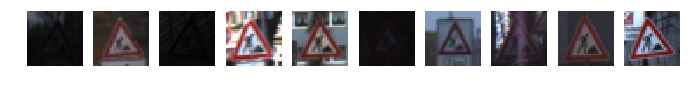

Traffic signals


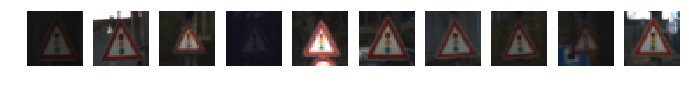

Pedestrians


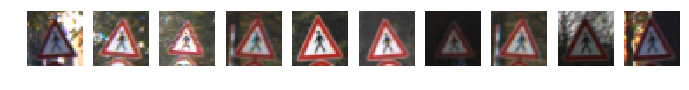

Children crossing


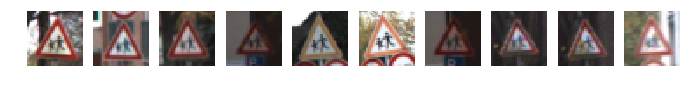

Bicycles crossing


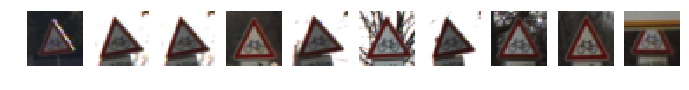

Beware of ice/snow


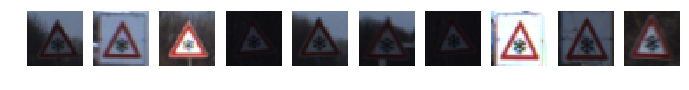

Wild animals crossing


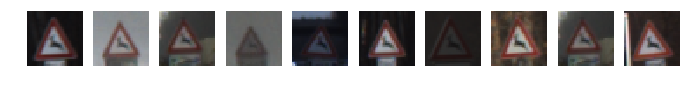

End of all speed and passing limits


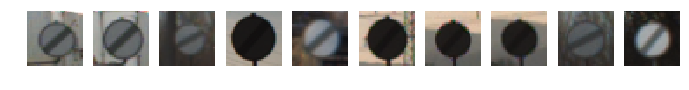

Turn right ahead


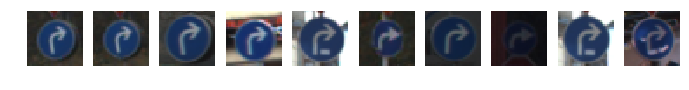

Turn left ahead


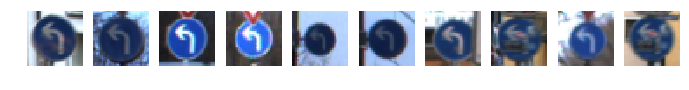

Ahead only


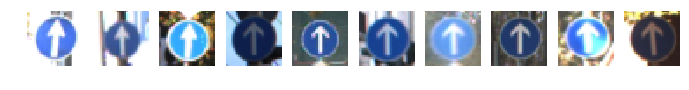

Go straight or right


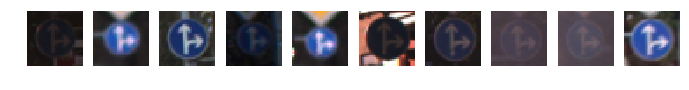

Go straight or left


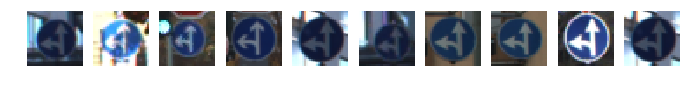

Keep right


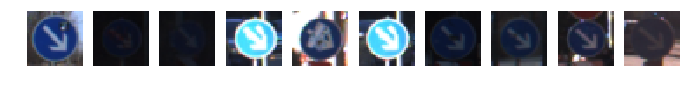

Keep left


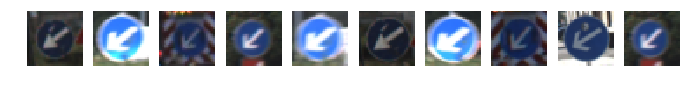

Roundabout mandatory


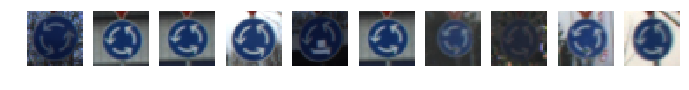

End of no passing


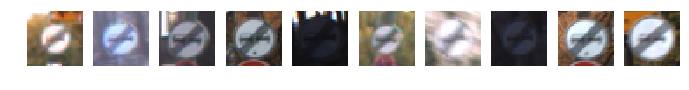

End of no passing by vehicles over 3.5 metric tons


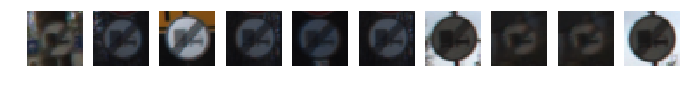

In [4]:
n = 10  # Examples to display

for c in range(n_classes):  # Iterate all classes
    idx = np.where(y_train == c)  # Find index for class
    n_images = x_train[np.random.choice(idx[0], n)]  # Pick n random images to display
    f, axes = plt.subplots(1, n)
    f.set_size_inches(A4_LANDSCAPE)
    print(signnames[c])
    for i, image in enumerate(n_images):
        axes[i].imshow(image)
        axes[i].grid(False)
        axes[i].axis('off')
    plt.show()

### Visualize class distribution

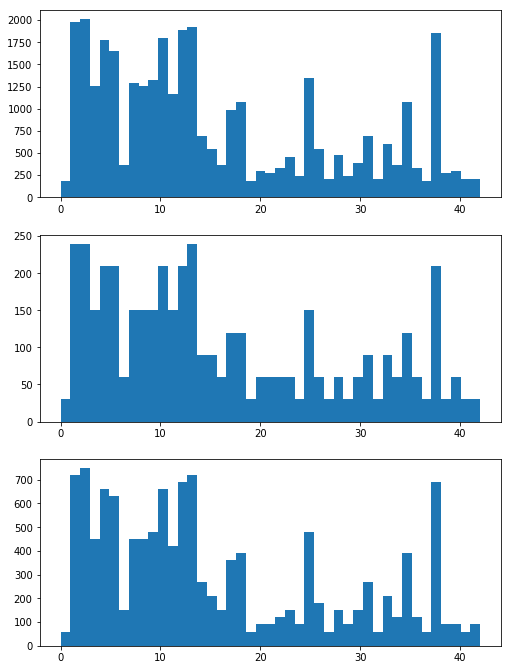

In [5]:
f, axes = plt.subplots(3, 1)
f.set_size_inches(A4_PORTRAIT)
for i, dataset in enumerate([y_train, y_valid, y_test]):
    axes[i].hist(dataset, bins=n_classes)

---
### Pre-process the Data Set

 Here decided to convert the images to grayscale as previous experiments show better results than using color images. Histogram equalization was applied to improve visibility of the signs and normalization with *zero mean* was used to facilitate the convergence of the optimizer during training.

In [6]:
def grayscale(image):
    return cv2.split(cv2.cvtColor(image, cv2.COLOR_RGB2YUV))[0]


def equalize(image):
    return cv2.equalizeHist(image)


def normalize_im(image):
    mini, maxi = np.min(image), np.max(image)
    return (image - mini) / (maxi - mini) * 2 - 1


def preprocess_im(image):
    return np.expand_dims(normalize_im(equalize(grayscale(image))), axis=2)


def preprocess(dataset):
    return np.array([preprocess_im(im) for im in dataset])


x_train_n = preprocess(x_train)
x_valid_n = preprocess(x_valid)
x_test_n = preprocess(x_test)

### Visualize pre-processing results

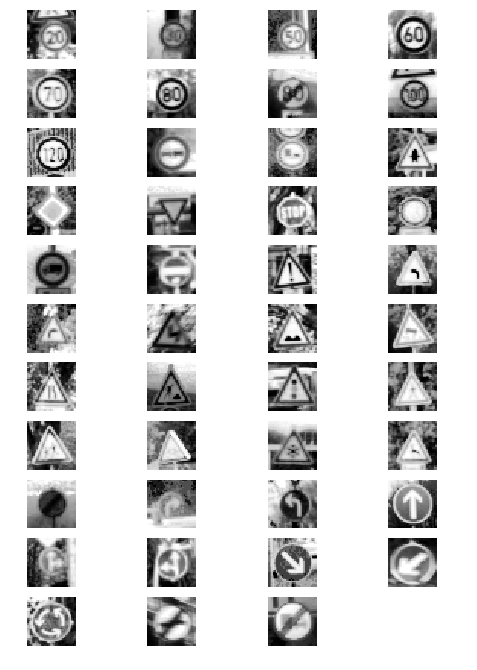

In [7]:
f, axes = plt.subplots(11, 4)
f.set_size_inches(A4_PORTRAIT)
c = 0
for row in axes:
    for ax in row:
        if c < n_classes:
            im = (x_train_n[np.random.choice(np.where(y_train == c)[0], 1)] + 1) / 2
            ax.imshow(im[0,:,:,0], cmap='gray')
        ax.grid(False)
        ax.axis('off')
        c += 1
plt.show()

### Dataset augmentation

 For a more robust model I have decided to augment the training dataset. This was also used to rebalance the number of examples for each class to eliminate biases in the final model.

In [8]:
def rotate(image, angle=15):
    angle = np.random.randint(-angle, angle)
    M = cv2.getRotationMatrix2D((16, 16), angle, 1)
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))


def translate(image, pixels=2):
    tx = np.random.choice(range(-pixels, pixels))
    ty = np.random.choice(range(-pixels, pixels))
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(src=image, M=M, dsize=(32, 32))


def random_bright(image):
    eff = 0.5 + np.random.random()
    return image * eff

def generate(images, count):
    generated = []
    while True:
        for image in images:
            if len(generated) == count:
                return generated
            image = random_bright(image)
            image = rotate(image)
            image = translate(image)
            image = normalize_im(image)
            generated.append(np.expand_dims(image, axis=2))


unique, counts = np.unique(y_train, return_counts=True)

target = 5000
x_augmented = []
y_augmented = []

for cls, count in tqdm(list(zip(unique, counts)), 'Augmenting training dataset'):
    diff = target - count
    x_augmented += generate(x_train_n[np.where(y_train == cls)[0]], diff)
    y_augmented += [cls for _ in range(diff)]

x_train_n = np.concatenate([x_train_n, np.array(x_augmented)])
y_train = np.concatenate([y_train, np.array(y_augmented)])
n_train = y_train.size
print('Final number of training examples', n_train)

Augmenting training dataset: 100%|██████████| 43/43 [00:28<00:00,  1.38it/s]


Final number of training examples 215000


### Visualize a few augmented examples

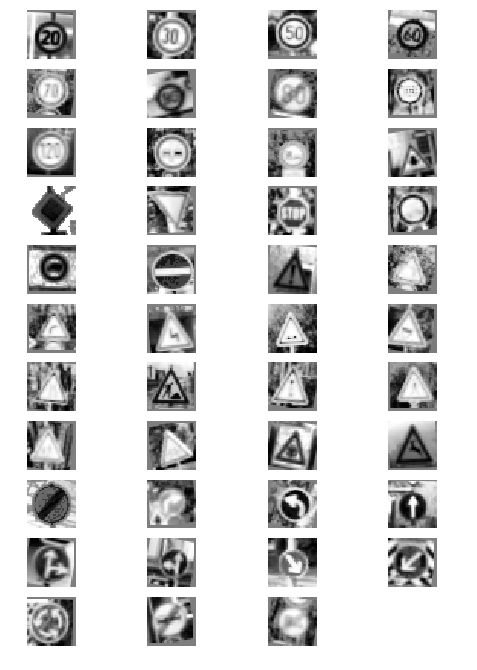

In [9]:
f, axes = plt.subplots(11, 4)
f.set_size_inches(A4_PORTRAIT)
c = 0
for row in axes:
    for ax in row:
        if c < n_classes:
            im = (x_train_n[np.random.choice(np.where(y_train == c)[0], 1)] + 1) / 2
            ax.imshow(im[0,:,:,0], cmap='gray')
        ax.grid(False)
        ax.axis('off')
        c += 1
plt.show()

---
## Define a Model Architecture

Here I have defined a few helper functions using the original Tensorflow API instead of using the new `tf.layers` to show how these are actually just mathematical operations on matrices.

In [10]:
def conv2d(x, kernel, input_depth, output_depth, stride=1, padding='VALID', mu=0, sigma=0.1):
    shape = (kernel, kernel, input_depth, output_depth)
    W = tf.Variable(tf.truncated_normal(shape=shape, mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_depth))
    conv = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    conv = tf.nn.bias_add(conv, b)
    return conv


def fully(x, input_size, output_size, mu=0, sigma=0.1):
    W = tf.Variable(tf.truncated_normal(shape=(input_size, output_size), mean=mu, stddev=sigma))
    b = tf.Variable(tf.zeros(output_size))
    fc = tf.matmul(x, W)
    fc = tf.add(fc, b)
    return fc


def max_pool(x, size, padding='VALID'):
    return tf.nn.max_pool(x, ksize=[1, size, size, 1], strides=[1, size, size, 1], padding=padding)


def traffic_net(x, keep_prob, mu=0, sigma=0.1):
    # 3x3 convolution with ReLU activation
    conv1 = conv2d(x, 3, 1, 12)
    conv1 = tf.nn.relu(conv1)

    # 3x3 convolution with ReLU activation
    conv1 = conv2d(conv1, 3, 12, 24)
    conv1 = tf.nn.relu(conv1)
    pool1 = max_pool(conv1, 2)

    # 5x5 convolution with ReLU activation
    conv2 = conv2d(pool1, 5, 24, 36)
    conv2 = tf.nn.relu(conv2)

    # 5x5 convolution with ReLU activation
    conv2 = conv2d(conv2, 5, 36, 48)
    conv2 = tf.nn.relu(conv2)
    pool2 = max_pool(conv2, 2)

    # Flatten and Concatenate
    flat1 = tf.contrib.layers.flatten(pool1)
    flat2 = tf.contrib.layers.flatten(pool2)
    flattened = tf.concat([flat1, flat2], axis=1)

    # First fully connected with 512 neurons and dropout to reduce variance
    fully1 = fully(flattened, 5136, 512)
    fully1 = tf.nn.relu(fully1)
    fully1 = tf.nn.dropout(fully1, keep_prob)

    # Second fully connected with 256 neurons and dropout to reduce variance
    fully2 = fully(fully1, 512, 256)
    fully2 = tf.nn.relu(fully2)
    fully2 = tf.nn.dropout(fully2, keep_prob)

    # Output layer
    return fully(fully2, 256, n_classes), conv1, conv2

---
## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing without being fooled by an overfit model.

In [11]:
batch_size = 32
keep_prob = .5
epochs = 100
patience = 3
modelname = 'traffic_net'


def generator(x_data, y_data, batch_size, shuffle=False, desc=None):
    if shuffle:
        x_data, y_data = sklearn.utils.shuffle(x_data, y_data)
    gen = range(0, len(x_data), batch_size)
    gen = tqdm(gen, desc) if desc is not None else gen
    for offset in gen:
        end = offset + batch_size
        yield x_data[offset:end], y_data[offset:end]


tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
kp = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, n_classes)

def evaluate(x_data, y_data, desc=None):
    total_accuracy = 0
    sess = tf.get_default_session()
    if desc is None:
        gen = generator(x_data, y_data, batch_size=batch_size)
    else:
        gen = generator(x_data, y_data, batch_size=batch_size, desc=desc)
    for x_batch, y_batch in gen:
        accuracy = sess.run(accuracy_operation, feed_dict={x: x_batch, y: y_batch, kp: 1.0})
        total_accuracy += (accuracy * len(x_batch))
    return total_accuracy / len(x_data)

# Exponential decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    learning_rate=0.0005,
    global_step=global_step,
    decay_steps=ceil(n_train / batch_size),  # Decay every epoch
    decay_rate=0.95,
    staircase=True)

logits, conv1, conv2 = traffic_net(x, kp)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

### Perform training

In [12]:
best_epoch = 0
best_val_acc = 0
history = []
with tf.Session() as sess:
    if os.path.exists('checkpoint'):
        print('Restore {}.cktp to continue training'.format(modelname))
        saver.restore(sess, tf.train.latest_checkpoint('.'))
    else:
        print("Training {}...".format(modelname))
        sess.run(tf.global_variables_initializer())

    try:
        for i in range(epochs):
            desc = "EPOCH {} ...".format(i + 1)
            sys.stdout.flush()
            for x_batch, y_batch in generator(x_train_n, y_train, batch_size=batch_size, shuffle=True, desc=desc):
                sess.run(training_operation, feed_dict={x: x_batch, y: y_batch, kp: keep_prob})

            train_acc = evaluate(x_train_n, y_train, desc='Evaluating training')
            val_acc = evaluate(x_valid_n, y_valid, desc='Evaluating validation')
            print("Training Accuracy = {:.3f}".format(train_acc))
            print("Validation Accuracy = {:.3f}".format(val_acc))

            history.append([train_acc, val_acc])
            if val_acc > best_val_acc:
                best_epoch, best_val_acc = i, val_acc
                saver.save(sess, './{}.ckpt'.format(modelname))
                print("Model saved")
            else:
                if i - best_epoch == patience:
                    print('Stopping after {} epochs without improvement'.format(patience))
                    break
    except KeyboardInterrupt:
        pass

Restore traffic_net.cktp to continue training
INFO:tensorflow:Restoring parameters from ./traffic_net.ckpt


Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 79.72it/s]


Training Accuracy = 1.000
Validation Accuracy = 0.993
Model saved


Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 78.28it/s]

Training Accuracy = 0.999
Validation Accuracy = 0.990



Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 77.95it/s]


Training Accuracy = 0.999
Validation Accuracy = 0.995
Model saved


Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 78.22it/s]

Training Accuracy = 0.999
Validation Accuracy = 0.994



Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 79.65it/s]

Training Accuracy = 1.000
Validation Accuracy = 0.991



Evaluating validation: 100%|██████████| 138/138 [00:01<00:00, 79.37it/s]

Training Accuracy = 1.000
Validation Accuracy = 0.993
Stopping after 3 epochs without improvement


### Evaluate the training history

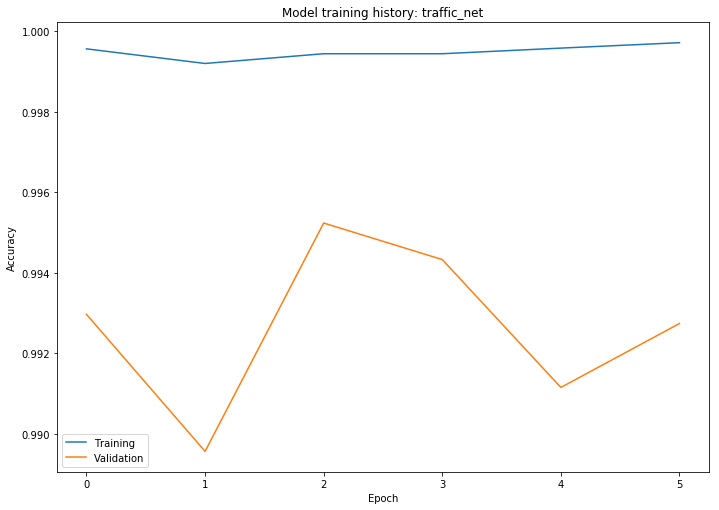

In [13]:
def plot_history(history, modelname):
    plt.figure(figsize=A4_LANDSCAPE)
    plt.title('Model training history: {}'.format(modelname))
    plt.plot(history)
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

plot_history(history, 'traffic_net')

---
## Evaluate the neural network accuracy

 Now that the neural network was trained it's time to evaluate its accuracy on the untouched test dataset.

In [17]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    print('Test accuracy: {:.3f}%'.format(evaluate(x_test_n, y_test) * 100))

    softmax = tf.nn.softmax(logits)
    t_pred = None
    for x_batch, y_batch in generator(x_test_n, y_test, batch_size):
        top_softmax = sess.run(tf.nn.top_k(softmax, k=3), feed_dict={x: x_batch, y: y_batch, kp: 1.0})
        if t_pred is None:
            t_pred = top_softmax[1]
        else:
            t_pred = np.concatenate([t_pred, top_softmax[1]])
    correct = np.sum([1 for t_pred, actual in zip(t_pred, y_test) if actual in t_pred])
    print('Top-3 test accuracy: {:.3f}%'.format(100 * correct / len(y_test)))

INFO:tensorflow:Restoring parameters from ./traffic_net.ckpt
Test accuracy: 97.443%
Top-3 test accuracy: 99.129%


### Plotting a confusion matrix

 One idea to further evaluate the results is using a confusion matrix.

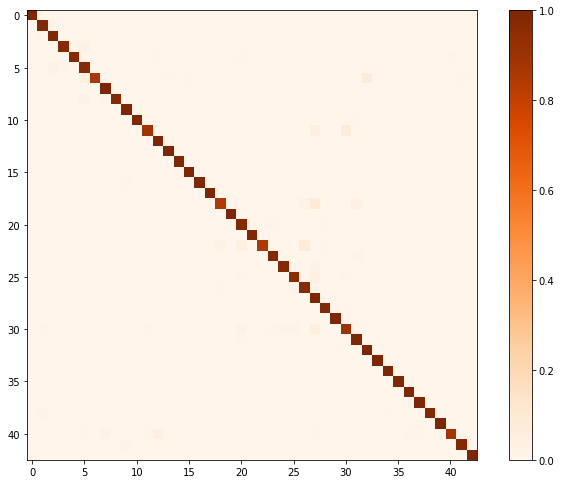

In [15]:
cm = confusion_matrix(y_test, t_pred[:, 0])
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
plt.figure(figsize=A4_LANDSCAPE)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Oranges)
plt.colorbar()

---

## Visualize the Neural Network's State with Test Images

 This Section acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

INFO:tensorflow:Restoring parameters from ./traffic_net.ckpt
Feature maps for No passing for vehicles over 3.5 metric tons


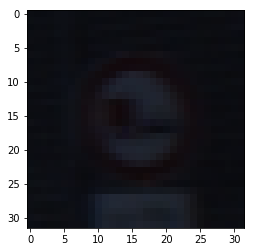

First convolutional layer
Second convolutional layer


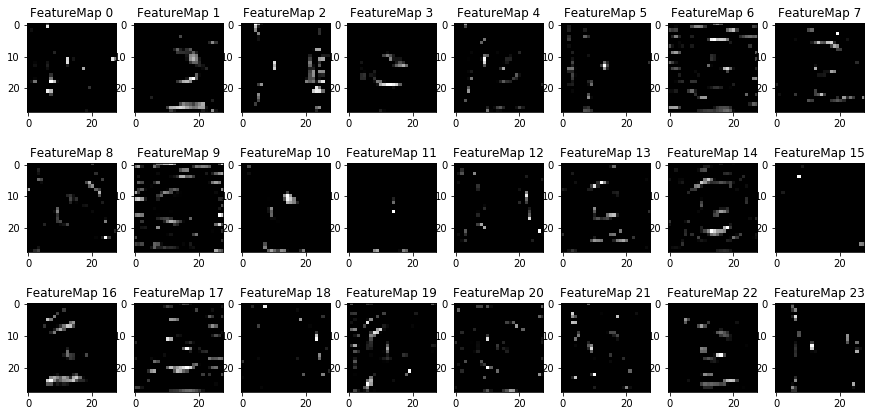

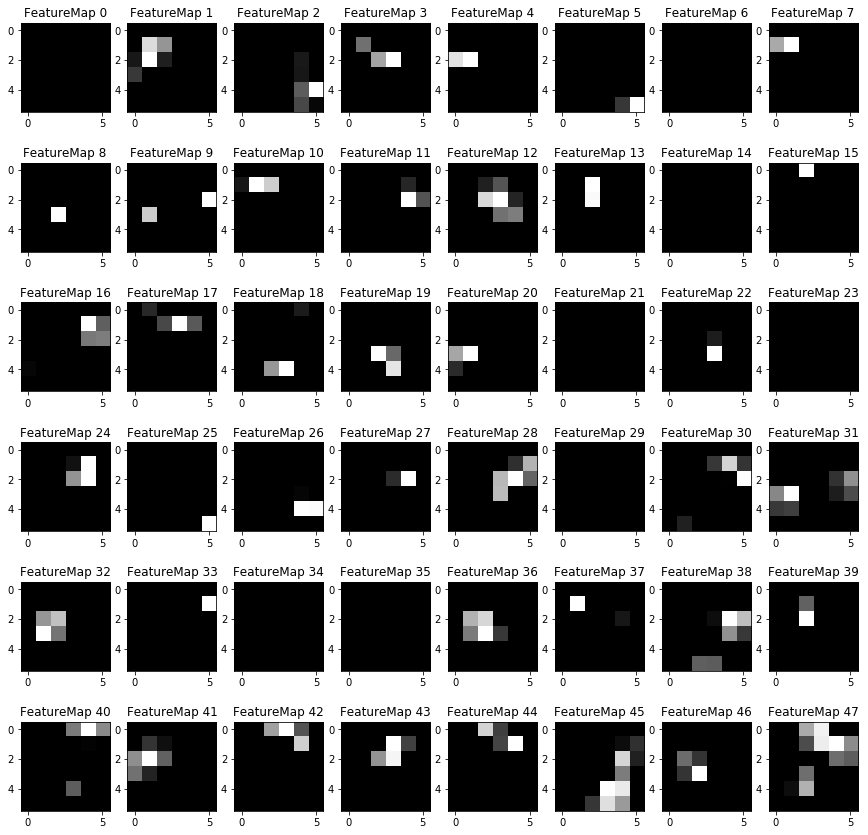

In [16]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    ix = int(np.random.random() * x_test_n.shape[0])
    random_image = np.expand_dims(x_test_n[ix], axis=0)
    print('Feature maps for', signnames[y_test[ix]])
    plt.imshow(x_test[ix])
    plt.show()
    print('First convolutional layer')
    outputFeatureMap(random_image, conv1, plt_num=1)
    print('Second convolutional layer')
    outputFeatureMap(random_image, conv2, plt_num=2)